# RNN Time Series example using Tensorflow
Justin Brandenburg, MapR Technologies

In [11]:
#What are we working with?
import sys
sys.version

'3.5.2 |Anaconda 4.2.0 (64-bit)| (default, Jul  2 2016, 17:53:06) \n[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]'

In [12]:
!pip install dask --upgrade

Requirement already up-to-date: dask in /opt/conda3/lib/python3.5/site-packages (1.0.0)


In [13]:
#Import Libraries
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import random
%matplotlib inline
import tensorflow as tf
import shutil
import tensorflow.contrib.learn as tflearn
import tensorflow.contrib.layers as tflayers
from tensorflow.contrib.learn.python.learn import learn_runner
import tensorflow.contrib.metrics as metrics
import tensorflow.contrib.rnn as rnn

In [14]:
#TF Version
tf.__version__

'1.4.1'

#### Generate some data

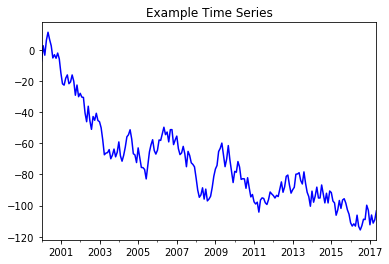

2000-01-31    -7.225782
2000-02-29     2.554329
2000-03-31    -3.521576
2000-04-30     6.086877
2000-05-31    11.192916
2000-06-30     6.475193
2000-07-31     2.466162
2000-08-31    -5.302594
2000-09-30    -3.223607
2000-10-31    -5.485203
Freq: M, dtype: float64

In [15]:
random.seed(111)
rng = pd.date_range(start='2000', periods=209, freq='M')
ts = pd.Series(np.random.uniform(-10, 10, size=len(rng)), rng).cumsum()
ts.plot(c='b', title='Example Time Series')
plt.show()
ts.head(10)

#### Convert data into array that can be broken up into training "batches" that we will feed into our RNN model.  Note the shape of the arrays. 

In [16]:
TS = np.array(ts)
num_periods = 20
f_horizon = 1  #forecast horizon, one period into the future

x_data = TS[:(len(TS)-(len(TS) % num_periods))]
x_batches = x_data.reshape(-1, 20, 1)

y_data = TS[1:(len(TS)-(len(TS) % num_periods))+f_horizon]
y_batches = y_data.reshape(-1, 20, 1)
print (len(x_batches))
print (x_batches.shape)
print (x_batches[0:2])

print (y_batches[0:1])
print (y_batches.shape)

10
(10, 20, 1)
[[[ -7.22578188]
  [  2.55432855]
  [ -3.52157607]
  [  6.08687668]
  [ 11.19291625]
  [  6.47519258]
  [  2.466162  ]
  [ -5.30259433]
  [ -3.22360692]
  [ -5.48520286]
  [ -2.16659023]
  [ -5.89051439]
  [-14.96445283]
  [-21.89795265]
  [-22.74170221]
  [-18.2873306 ]
  [-16.17585797]
  [-21.81173688]
  [-20.64943375]
  [-16.20113461]]

 [[-20.23256283]
  [-29.21999947]
  [-22.67310977]
  [-30.15701498]
  [-27.99051122]
  [-30.40707417]
  [-30.61085594]
  [-40.5781508 ]
  [-46.20341906]
  [-36.2556854 ]
  [-45.46838663]
  [-51.08772253]
  [-42.85984683]
  [-45.27730854]
  [-40.7815858 ]
  [-45.39167483]
  [-46.2356782 ]
  [-50.08570966]
  [-57.85545283]
  [-67.39074636]]]
[[[  2.55432855]
  [ -3.52157607]
  [  6.08687668]
  [ 11.19291625]
  [  6.47519258]
  [  2.466162  ]
  [ -5.30259433]
  [ -3.22360692]
  [ -5.48520286]
  [ -2.16659023]
  [ -5.89051439]
  [-14.96445283]
  [-21.89795265]
  [-22.74170221]
  [-18.2873306 ]
  [-16.17585797]
  [-21.81173688]
  [-20.64943

#### Pull out our test data

In [17]:
def test_data(series,forecast,num_periods):
    test_x_setup = TS[-(num_periods + forecast):]
    testX = test_x_setup[:num_periods].reshape(-1, 20, 1)
    testY = TS[-(num_periods):].reshape(-1, 20, 1)
    return testX,testY

X_test, Y_test = test_data(TS,f_horizon,num_periods )
print (X_test.shape)
print (X_test)

(1, 20, 1)
[[[ -95.58927202]
  [ -98.38553136]
  [-102.70232297]
  [-105.50648339]
  [-111.07460867]
  [-113.12848836]
  [-111.69792595]
  [-113.14068095]
  [-106.13746208]
  [-113.37401551]
  [-115.59939383]
  [-112.84965897]
  [-108.75759481]
  [-108.955779  ]
  [ -99.75472563]
  [-103.06040211]
  [-112.28301673]
  [-106.03010239]
  [-111.22897551]
  [-109.13301034]]]


In [18]:
tf.reset_default_graph()   #We didn't have any previous graph objects running, but this would reset the graphs

num_periods = 20      #number of periods per vector we are using to predict one period ahead
inputs = 1            #number of vectors submitted
hidden = 100          #number of neurons we will recursively work through, can be changed to improve accuracy
output = 1            #number of output vectors

X = tf.placeholder(tf.float32, [None, num_periods, inputs])   #create variable objects
y = tf.placeholder(tf.float32, [None, num_periods, output])


basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=hidden, activation=tf.nn.relu)   #create our RNN object
rnn_output, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)               #choose dynamic over static

learning_rate = 0.001   #small learning rate so we don't overshoot the minimum

stacked_rnn_output = tf.reshape(rnn_output, [-1, hidden])           #change the form into a tensor
stacked_outputs = tf.layers.dense(stacked_rnn_output, output)        #specify the type of layer (dense)
outputs = tf.reshape(stacked_outputs, [-1, num_periods, output])          #shape of results
 
loss = tf.reduce_sum(tf.square(outputs - y))    #define the cost function which evaluates the quality of our model
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)          #gradient descent method
training_op = optimizer.minimize(loss)          #train the result of the application of the cost_function                                 

init = tf.global_variables_initializer()           #initialize all the variables

In [19]:
epochs = 1000     #number of iterations or training cycles, includes both the FeedFoward and Backpropogation

with tf.Session() as sess:
    init.run()
    for ep in range(epochs):
        sess.run(training_op, feed_dict={X: x_batches, y: y_batches})
        if ep % 100 == 0:
            mse = loss.eval(feed_dict={X: x_batches, y: y_batches})
            print(ep, "\tMSE:", mse)
    
    y_pred = sess.run(outputs, feed_dict={X: X_test})
    print(y_pred)

0 	MSE: 755072.25
100 	MSE: 18511.057
200 	MSE: 6887.7803
300 	MSE: 2523.659
400 	MSE: 1840.9768
500 	MSE: 1592.491
600 	MSE: 1478.4829
700 	MSE: 1344.0952
800 	MSE: 1242.9237
900 	MSE: 1356.7424
[[[ -98.647285]
  [ -96.94811 ]
  [-104.3007  ]
  [-105.0754  ]
  [-112.91132 ]
  [-119.93038 ]
  [-114.901535]
  [ -98.40806 ]
  [-116.65237 ]
  [-122.72338 ]
  [-108.83105 ]
  [-114.70511 ]
  [-113.34284 ]
  [-101.34017 ]
  [-103.380486]
  [-106.372765]
  [-113.43501 ]
  [-120.10575 ]
  [-105.10554 ]
  [ -93.899345]]]


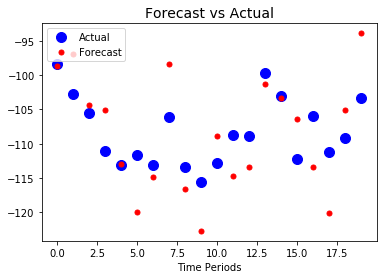

In [20]:
plt.title("Forecast vs Actual", fontsize=14)
plt.plot(pd.Series(np.ravel(Y_test)), "bo", markersize=10, label="Actual")
#plt.plot(pd.Series(np.ravel(Y_test)), "w*", markersize=10)
plt.plot(pd.Series(np.ravel(y_pred)), "r.", markersize=10, label="Forecast")
plt.legend(loc="upper left")
plt.xlabel("Time Periods")

plt.show()

